# For Visual Category Data (imgclust)

pickle file: fitted_model_object3.pkl

numstarts = 10

number of time bins = 3

pi_off = 15000.

delta = 1e-4

fr_shape_rate = 1e-4 * np.ones(K)

time_natural = False

od natural prior shape = 1.01

od natural prior rate  = .01 to make the mode = 1

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import cPickle as pickle
from spiketopics.helpers import *

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter

import scipy.io as sio
from collections import namedtuple
from sklearn.linear_model import LogisticRegression

%matplotlib inline
savefig = False

## 1. Original data

This part is to show how the original data is like.

In [2]:
# Show the prepared data to run the model
df = pd.read_csv('data/prepped_data03.csv')
df.head()

,trial,unit,count,category,time
0,69,0,2,Baseline,0
1,69,1,1,Baseline,0
2,69,2,2,Baseline,0
3,69,3,0,Baseline,0
4,69,4,3,Baseline,0


In [3]:
# compute time interval
bins = 3
bin_stim = 1
dt = .900 / bins

dfm = df.groupby(['time', 'unit']).mean()['count'].unstack(level=0)

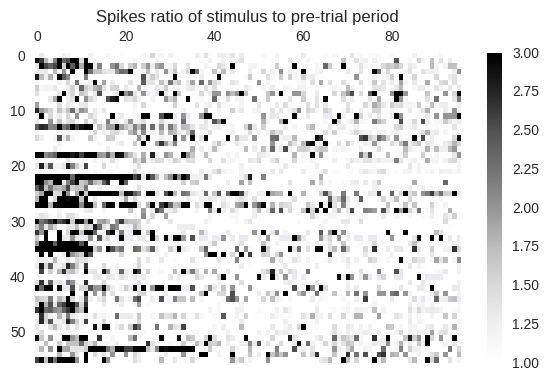

In [4]:
sns.set_style('darkgrid', {'axes.grid' : False})

# plot the spikes ratio of stimulus to the time bin before stimulus
for i in range(bin_stim):
    plt.matshow(dfm.values[:, bin_stim::bins] / dfm.values[:, i::bins], 
            aspect='auto', vmin=1, vmax=3)
    plt.colorbar();
    plt.title('Spikes ratio of stimulus to pre-trial period'.format(str(i)), y=1.08)


<Container object of 3 artists>

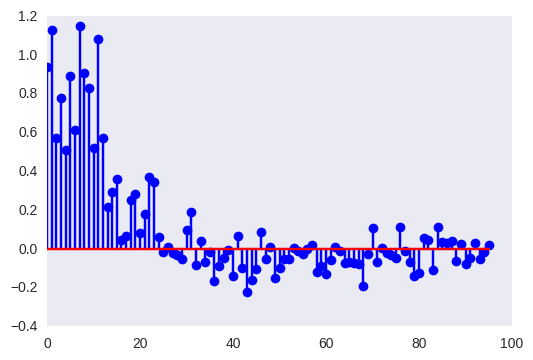

In [5]:
# plot the stimulus ratio
dfmm = df.groupby('time').mean()['count']
dfrel = (dfmm.values[bin_stim::bins] - dfmm.values[::bins])/dfmm.values[::bins]
plt.stem(range(len(dfrel)), dfrel)

## 2. Load outputs from model inference

Note: We packed model inference in a pickle file for conveniences; and the following part is to show the result.

In [6]:
infile = 'output/pickles/fitted_model_object3seed12345.pkl'

# number of neurons & stimuli
Nu = 56
Nstim = 96

with open(infile, 'rb') as f:
    gpm = pickle.load(f)

### Plot inferred categories as matrix

In [7]:
xi = gpm.nodes['HMM'].nodes['z'].z[1].copy()
T, K = xi.shape

#### Ignore the following block since it is only for better visualization purposes

In [8]:
th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

effsize = th_pars[1] / (th_pars[0] - 1)  # mean of posterior for mean effect size
X = (effsize ** xi[bin_stim::bins]).T
Xcopy = X.copy()

# Sort rows of X according to their magnitudes
Xcopy[(np.abs(Xcopy - 1) < 1e-3)] = np.nan
idx = np.argsort(np.nanmax(Xcopy, axis=1))[::-1]
X = np.take(X, idx, axis=0)

#### ... Contiue ......

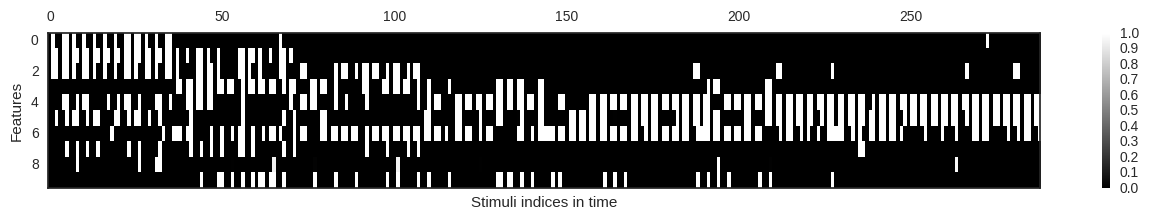

In [9]:
# states of z
xi = np.take(xi, idx, axis=1)
matshow(xi.T, aspect = 'auto', vmin=0, vmax=1);
plt.xlabel('Stimuli indices in time')
plt.ylabel('Features')
plt.colorbar();

Every third timestep is a different stimulus. Each stimulus has
1. pre-trial baseline
1. stimulus presentation
1. post-stimulus period

So let's plot these individually:

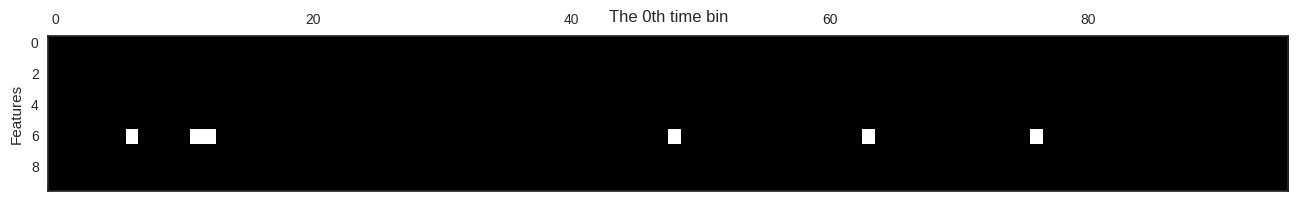

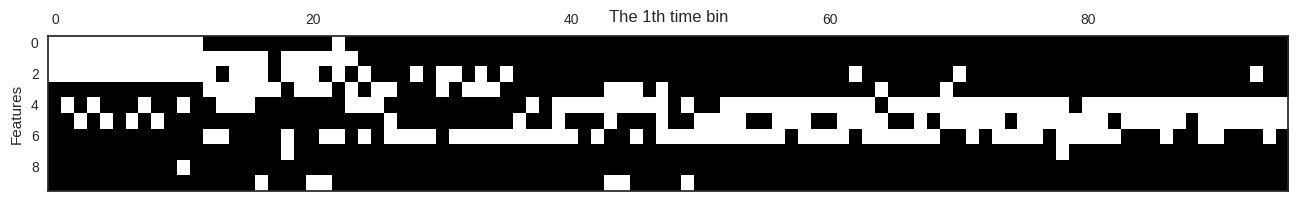

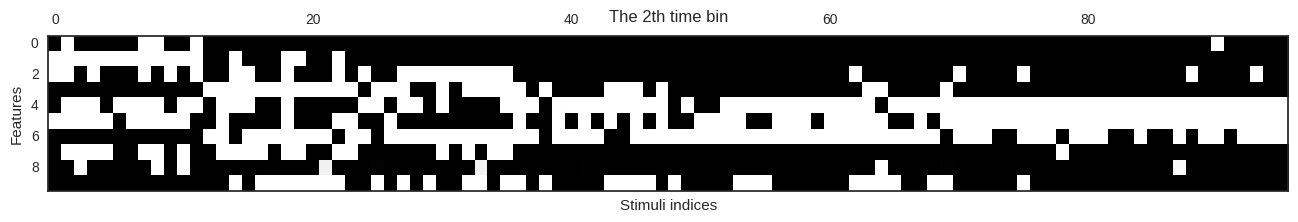

In [10]:
for i in range(bins):
    matshow(xi[i::bins].T, aspect='auto', vmin=0, vmax=1)
    plt.ylabel('Features')
    plt.title('The {}th time bin'.format(str(i)))
    
plt.xlabel('Stimuli indices')

Here a bright block means that a given feature is ON for given stimulus, and a dark block means the feature is OFF for corresponding stimulus.

Now let's take a look at the difference between consecutive time bins closely:

In [11]:
# make a normalizer so we can set the colormap midpoint
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_invalid(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=1., vmin=0.7, vmax=1.3)
cmap = plt.cm.RdBu_r
cmap.set_bad(color='k', alpha=1.0)

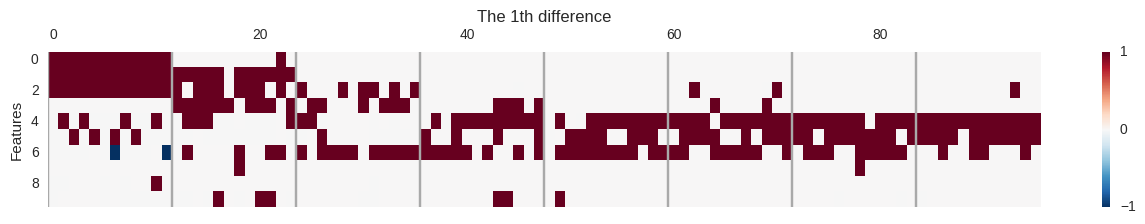

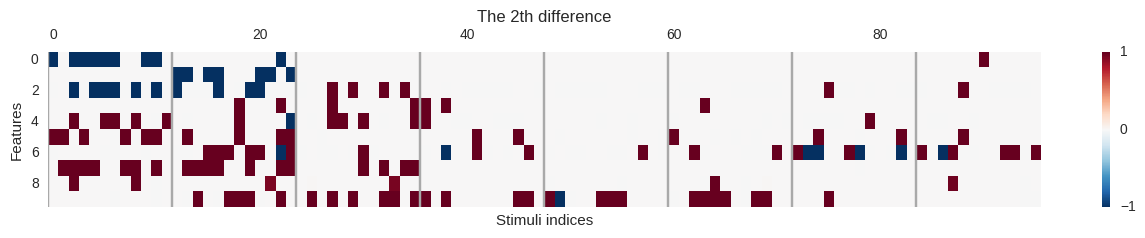

In [12]:
# show the difference between two consecutive time bins
for i in range(1, bins):
    plt.matshow(xi[i::bins].T - xi[i-1::bins].T, vmin=-1, vmax=1, aspect='auto', cmap=cmap)
    for ind in range(0, xi.shape[0] // bins, 12):
        plt.axvline(ind - 0.5, 0, xi.shape[-1], color='darkgrey')
    
    cbar = plt.colorbar()
    cbar.set_ticks([-1, 0, 1])
    
    plt.ylabel('Features')
    plt.title('The {}th difference'.format(str(i)), y=1.15)
    
plt.xlabel('Stimuli indices')

## 3. Weight features by effect sizes

From above we have successfully inferred the features ON/OFF states. However, those features are weighted differently because neurons might have specific interests to stimuli in certain categories. Thus we want to get the mean effect size and evaluate their impact on firing rates. 

First, get mean effect size for each firing rate effect:

We have
$$
\lambda_u \sim \mathrm{Ga}(c, c\theta)
$$
so 
$$
\mathbb{E}[\lambda_u] = \mathbb{E}\left[\frac{c}{c\theta}\right] = \mathbb{E}[\theta^{-1}] = \frac{r_\theta}{s_\theta - 1}
$$
where $r_\theta$ and $s_\theta$ are the rate and shape parameters for $\theta$, respectively.

In [13]:
th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

effsize = th_pars[1] / (th_pars[0] - 1)  # mean of posterior for mean effect size

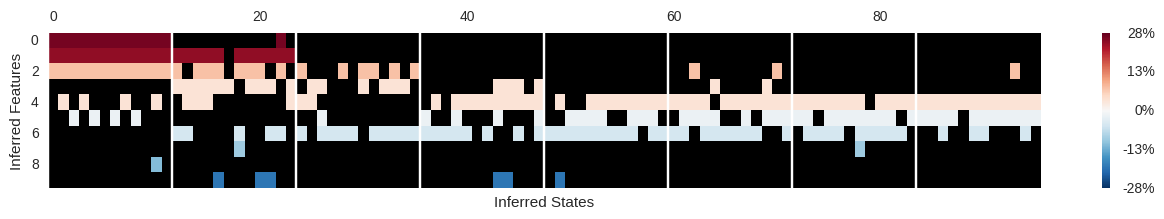

In [14]:
# Plot effect sizes in color corresponding to each feature
Xcopy = X.copy()
logXcopy = np.log(Xcopy)
logXcopy[(np.abs(logXcopy) < 1e-3)] = np.nan

if savefig:
    sns.set_context('talk')
    sns.set_style('white')

norm = MidpointNormalize(midpoint=0., vmin=-.25, vmax=.25)
ax = plt.matshow(logXcopy, aspect='auto', cmap=cmap, norm=norm);

for ind in range(0, xi.shape[0] // bins, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='white')

plt.xlabel('Inferred States')
# plt.yticks(xrange(len(features)), features)
plt.ylabel('Inferred Features')

cbar = plt.colorbar();
cbar.set_ticks([-.25, -.125, 0, .125, .25])
cbar.set_ticklabels(['-28%', '-13%', '0%', '13%', '28%'])

for t in cbar.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(5.5)
    
if savefig:
    plt.savefig("imgclust_detailed_cats.svg", format="svg", bbox_inches='tight')
    sns.set()
    sns.set_context('talk')
    sns.set_style('white')
    

## 3. Plot posteriors for effects

### 3.1 Posteriors for Baselines

In [15]:
bl = gpm.nodes['baseline']
unit_baseline_means = bl.expected_x() / dt

/home/xinchen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:1970: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._random_state.standard_gamma(a, self._size)


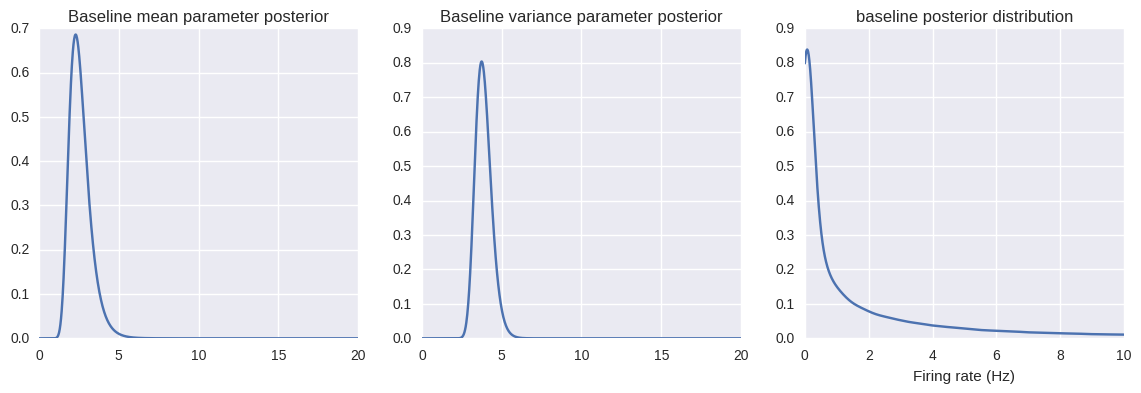

In [16]:
sns.set_style('darkgrid', {'axes.grid' : True})
plt.figure(figsize=(14, 4))

# get parameters from model and draw samples based on parameters
th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

# makes plots
plt.subplot(1, 3, 1)
xx = np.linspace(0, 20, 1000)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 1000)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 10);

### 3.2 Posteriors for regressors (if any)

In [17]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

### 3.3 Posteriors for Latent Categories

In [18]:
frn = gpm.nodes['fr_latents']
fr_mean_effect = frn.expected_x()

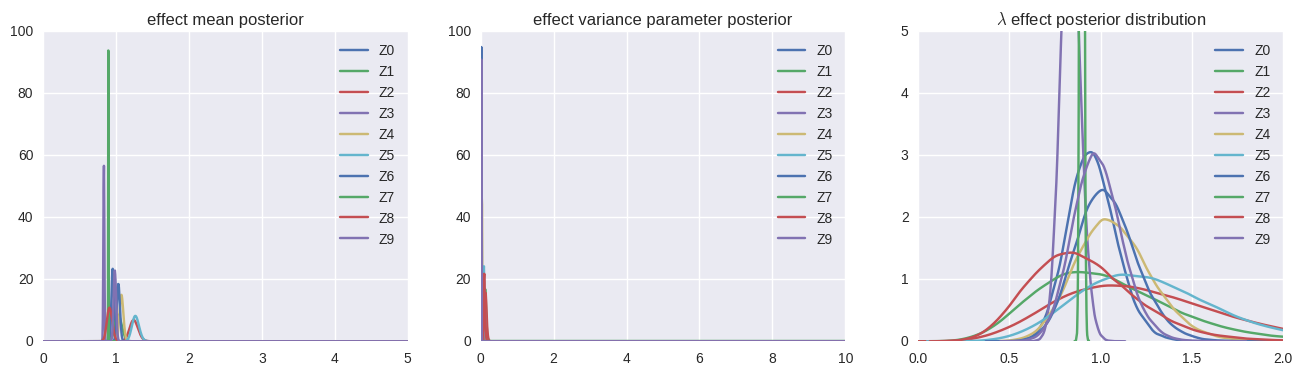

In [19]:
plt.figure(figsize=(16, 4))

# get parameters from model and draw samples based on parameters
th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']
th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

# makes plots with samples
plt.subplot(1, 3, 1)
xx = np.linspace(0, 5, 1000)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 10, 1000)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
    
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

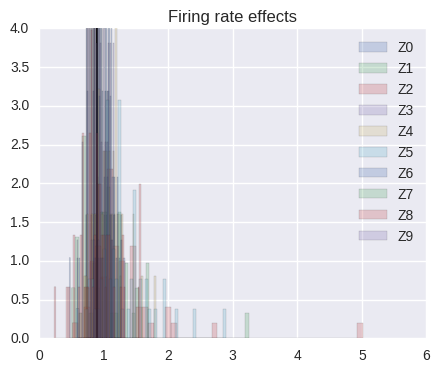

In [20]:
plt.figure(figsize=(5, 4))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');

# for better visualization; the peak can reach 1600
plt.ylim(0, 4);

### 3.4 Sparsity

In [21]:
if 'fr_latents_feature' in gpm.nodes:
    matshow(gpm.nodes['fr_latents_feature'].expected_x().T)

    gpm.nodes['fr_latents_sparsity'].expected_x()[0]

### 3.5 Overdispersion

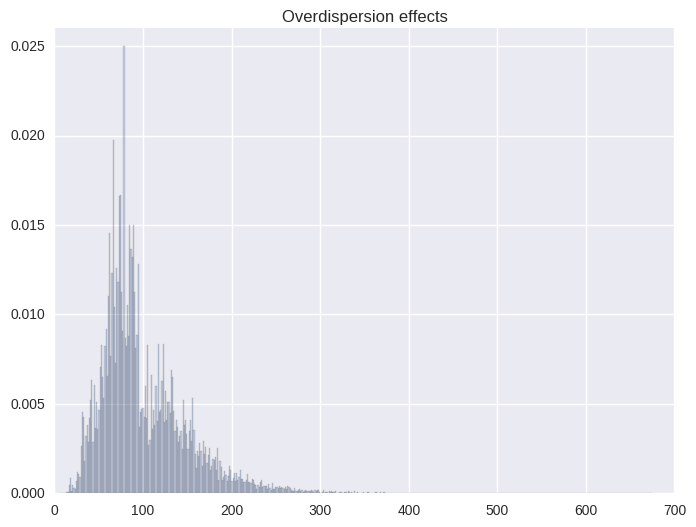

In [22]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, .026);

### 3.6 Overdispersion in autocorrelated time

In [23]:
if gpm.overdispersion_natural:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion_natural'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 7);

## 4. Load and prepare coded features:

## 4. Results for inferred states

### 4.1 Inferred categories with gain in firing rates

In [24]:
categories = ['Faces', 'Animals', 'Bodies', 'Fruit', 'Natural', 'Manmade', 'Scene', 'Pattern']
features = []
for i in range(10):
    features.append("Feature {}".format(i))

# generate category dataframe
df2 = df.copy()
df2['value'] = 1
df2 = df2.drop(['trial', 'unit'], axis=1).drop_duplicates()
catdf = pd.pivot_table(df2, values='value', index=['time'], columns=['category']).reset_index().fillna(0)
catdf.columns.name = ''

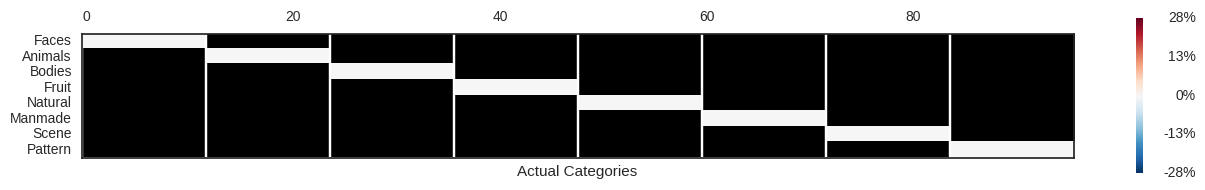

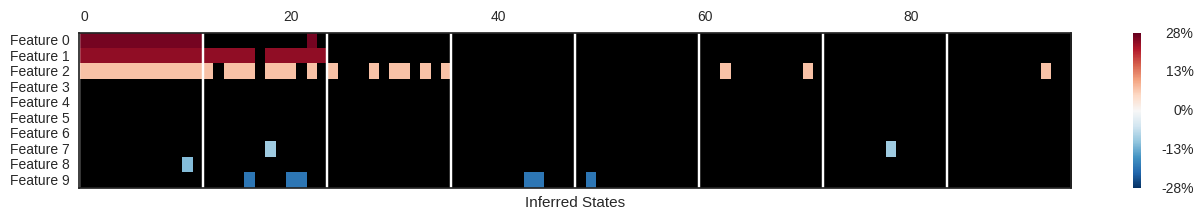

In [25]:
# plot inferred categories with gain 
cat = pd.DataFrame.as_matrix(catdf.iloc[1::3][categories]).T
cat[cat < 5e-2] = np.nan

if savefig:
    sns.set_context('talk')
    sns.set_style('white')

# show category
with sns.axes_style("white"):
    norm = MidpointNormalize(midpoint=0., vmin=-.25, vmax=.25
                            )
    ax = plt.matshow(np.log(cat), aspect=1.5, cmap=cmap, norm=norm);

for ind in range(0, xi.shape[0] // bins, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='white')
plt.xlabel('Actual Categories')
plt.yticks(xrange(len(categories)), categories)
cbar = plt.colorbar()
cbar.set_ticks([-.25, -.125, 0, .125, .25])
cbar.set_ticklabels(['-28%', '-13%', '0%', '13%', '28%'])

for t in cbar.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(6.5)

if savefig:
    plt.savefig("imgclust_actual.svg", format="svg", bbox_inches='tight')
    sns.set()
    sns.set_context('talk')
    sns.set_style('white')

# show inferred states
logXcopy[abs(logXcopy) < 5e-2] = np.nan

with sns.axes_style("white"):
    norm = MidpointNormalize(midpoint=0., vmin=-.25, vmax=.25)
    ax = plt.matshow(logXcopy, aspect='auto', cmap=cmap, norm=norm);

for ind in range(0, xi.shape[0] // bins, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='white')
plt.xlabel('Inferred States')
plt.yticks(xrange(len(features)), features)

cbar = plt.colorbar();
cbar.set_ticks([-.25, -.125, 0, .125, .25])
cbar.set_ticklabels(['-28%', '-13%', '0%', '13%', '28%'])

for t in cbar.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(6.5)

if savefig:
    plt.savefig('imgclust_inferred.svg', format="svg", bbox_inches='tight')
    sns.set()


### Take a closer look to the first two categories...

In [26]:
logXcopy = np.log(Xcopy)
logXcopy[np.abs(logXcopy) < 1e-3] = np.nan

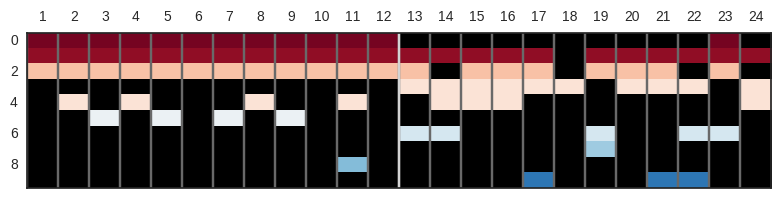

In [27]:
# zoom in to see first two categories
if savefig:
    sns.set_context('talk')
    sns.set_style('white')

with sns.axes_style("white"):
    ax = plt.figure(figsize=(20, 8))
    frame = plt.matshow(logXcopy[:, :24], aspect=.5, cmap=cmap, norm=norm)

for ind in range(0, 24):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='dimgrey')

plt.axvline(11.5, 0, xi.shape[-1], color='lightgrey')
plt.xticks(xrange(24), xrange(1, 25))

if savefig:
    plt.savefig('imgclust_2cat.svg', format="svg", bbox_inches='tight')
    sns.set()

### 4.2 Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [28]:
categories = ['Faces', 'Animals', 'Bodies', 'Fruit', 'Natural', 'Manmade', 'Scene', 'Pattern']
cat = pd.DataFrame.as_matrix(catdf.iloc[1::3][categories]).T

In [29]:
match = (np.dot(cat, xi[1::3]) + np.dot((1 - cat), (1 - xi[1::3]))) / 96
mismatch = (np.dot(cat, (1 - xi[1::3])) + np.dot((1 - cat), xi[1::3])) / 96
overlap = np.maximum(match, mismatch)

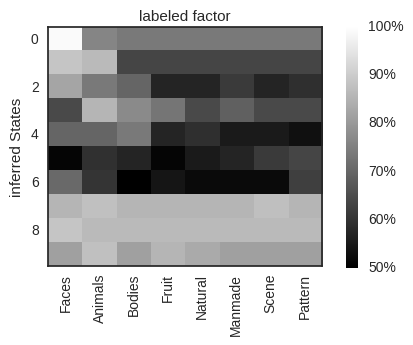

In [30]:
# show normalized overlap matrix in grey scale
matshow(overlap.T, aspect=.7, vmin=.5, vmax=1)

cbar = plt.colorbar(fraction=0.039, pad=0.08)
cbar.set_ticks([.5, .6, .7, .8, .9, 1])
cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])

plt.ylabel('inferred States')
plt.xlabel('labeled factor')

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(categories)), categories, rotation='vertical', horizontalalignment='center');

### 4.3 Mutual Information

In [31]:
# calculate mutual information
cat = pd.DataFrame.as_matrix(catdf.iloc[1::3][categories]).T

mi_mat = mutual_information_matrix(cat.T, xi[bin_stim::bins])

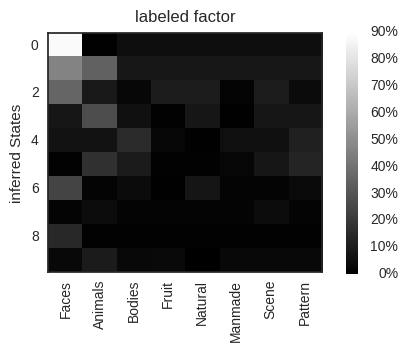

In [32]:
# plot mutual information matrix in grey scale
plt.figure()
matshow(mi_mat.T, aspect=0.7, vmin=0, vmax=.9)

plt.ylabel('inferred States')
plt.title('labeled factor', y=1.02)

cbar = plt.colorbar(fraction=0.039, pad=0.08)
cbar.set_ticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9])
cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
for t in cbar.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(3.5)

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(categories)), categories, rotation='vertical', horizontalalignment='center');

## 5. Categorization from inferred features and raw data

### 5.1 Softmax from Raw Data

In [33]:
# load data
datmat = sio.loadmat('data/toroid20120718a.mat')['dat']

# get header
header = datmat['h'][0][0]

# get events (trial x time)
evtdat = datmat['c'][0][0]
evtnames = header['vv'][0][0][0].dtype.names
evt = pd.DataFrame(evtdat, columns=evtnames[:10])
evt = evt.set_index('TR')

In [34]:
spk = datmat['s'][0][0]
header = datmat['h'][0]

Nt, _, Nu = spk.shape

In [35]:
# make a list of categories for the stims:
categories = ['Faces', 'Animals', 'Bodies', 'Fruit', 'Natural', 'Manmade', 'Scene', 'Pattern']

# create a named tuple of observations
# movie is the stimulus and frame the time within that trial
# these conventions are to match the ethogram data and for use below
names = ['trial', 'frame', 'unit', 'count', 'movie', 'category']
Obs = namedtuple('Obs', names)

In [36]:
# now loop over trials, then units within trial, counting spikes
# we count spikes in three intervals:
#   T_PRE:T_STIMON  pre-trial baseline
#   T_STIMON:T_STIMOFF  stimulus presentation
#   T_STIMOFF:T_POST  post-stimulus
tuplist = []  # accumulate observations here
for t in evt.itertuples():
    trial = int(t.Index)
    epochs = [(t.T_PRE, t.T_STIMON), (t.T_STIMON, t.T_STIMOFF),
    (t.T_STIMOFF, t.T_POST)]
    for unit in range(Nu):
        for epnum, ep in enumerate(epochs):
            t_spk = spk[trial - 1, :, unit]
            Nspk = np.sum((t_spk >= ep[0]) & (t_spk <= ep[1]))
            cat = categories[(int(t.STIM) - 1) // 12]
            if epnum == 0:  # baseline has no category
                cat = 'Baseline'
            tuplist.append(Obs(trial, epnum, unit, Nspk, int(t.STIM), cat))

In [37]:
# concatenate into dataframe
dfdata = pd.DataFrame.from_records(tuplist, columns=names)
dfdata = dfdata.sort_values(by=['movie', 'frame', 'trial', 'unit'])

In [38]:
dfstim = dfdata[dfdata['frame'] == 1]
dfstim_group = dfstim.groupby(['movie', 'unit']).mean() / dt
dfstim_group = dfstim_group.reset_index()
dfstim_group = dfstim_group.drop(['trial', 'frame'], axis=1)

In [39]:
dfpivot = dfstim_group.pivot(index='movie', columns='unit', values='count')
dfpivot = dfpivot.reset_index(drop=True)

In [40]:
Ycat = pd.DataFrame(np.repeat(range(1, 9), 12))
logreg = LogisticRegression(C=1e5)


#### L1 regularization

In [41]:
hrate_data1 = []
logreg = LogisticRegression(C=1e5, penalty='l1', random_state=12345)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(dfpivot, Ycat)
for start in range(8):
    end = start +1
    hit = 0

    for i in range(start*12, end*12):
        exidx = dfpivot.index.isin([i])
        logreg.fit(dfpivot.iloc[~exidx, :], Ycat.iloc[~exidx])
        Yhat = logreg.predict(dfpivot.iloc[exidx, :])
        hit += int(Ycat.iloc[exidx].values == Yhat)

    hrate_data1.append(float(hit) / ((end - start) * 12))


/home/xinchen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### L2 regularization

In [42]:
hrate_data2 = []
logreg = LogisticRegression(C=1e5, penalty='l2', random_state=12345)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(dfpivot, Ycat)
for start in range(8):
    end = start +1
    hit = 0

    for i in range(start*12, end*12):
        exidx = dfpivot.index.isin([i])
        logreg.fit(dfpivot.iloc[~exidx, :], Ycat.iloc[~exidx])
        Yhat = logreg.predict(dfpivot.iloc[exidx, :])
        hit += int(Ycat.iloc[exidx].values == Yhat)

    hrate_data2.append(float(hit) / ((end - start) * 12))


### 5.2 Softmax from model inferred features

In [43]:
# dfstim = df[df['time'] == 1]
# dfstim.groupby(['trial', 'unit'])

In [44]:
# insert all pairwise interaction terms
Z = pd.DataFrame(X.T)
# Z = pd.DataFrame(effsize ** xi[bin_stim::bins])
for i in range(10):
    for j in range(i+1, 10):
        colname = '{}{}'.format(i, j)
        Z[colname] = Z.iloc[:, i] * Z.iloc[:, j]

#### L1 regularization

In [45]:

hrate_model1 = []
logreg1 = LogisticRegression(C=1e5, penalty='l1')

for start in range(8):
    end = start +1
    hit = 0
#     logreg = LogisticRegression(C=1e5, penalty='l1')

    for i in range(start*12, end*12):
        exidx = Z.index.isin([i])
        logreg.fit(Z.iloc[~exidx, :], Ycat.iloc[~exidx])
        Yhat = logreg.predict(Z.iloc[exidx, :])
        hitsum = int(Ycat.iloc[exidx].values == Yhat)
        hit += hitsum
    hrate_model1.append(float(hit) / ((end - start) * 12)) #((end - start) * 12 * 56)


#### L2 regularization

In [46]:
hrate_model2 = []
logreg2 = LogisticRegression(C=1e5, penalty='l2')

for start in range(8):
    end = start +1
    hit = 0
#     logreg = LogisticRegression(C=1e5, penalty='l1')

    for i in range(start*12, end*12):
        exidx = Z.index.isin([i])
        logreg.fit(Z.iloc[~exidx, :], Ycat.iloc[~exidx])
        Yhat = logreg.predict(Z.iloc[exidx, :])
        hitsum = int(Ycat.iloc[exidx].values == Yhat)
        hit += hitsum
    hrate_model2.append(float(hit) / ((end - start) * 12)) #((end - start) * 12 * 56)


### 5.3 Summary Plots

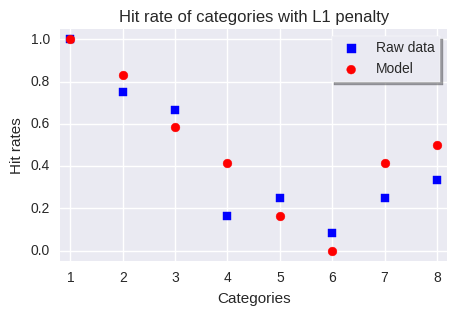

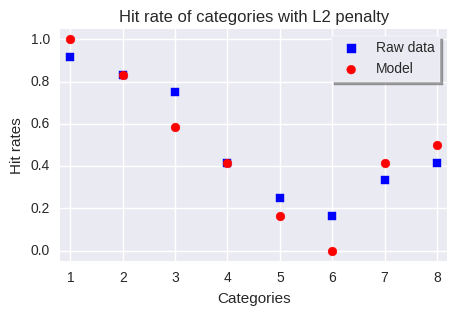

In [47]:
#plt.figure(figsize=(5,3))

if savefig:
    sns.set_context('talk')
    sns.set_style('white', {'axes.grid' : True})

plt.figure(figsize=(5, 3))
axdata = plt.scatter(range(1, 9), hrate_data1, s=40, marker='s', color='b')
axmodel = plt.scatter(range(1, 9), hrate_model1, s=40, color='r')
plt.legend([axdata, axmodel], ['Raw data', 'Model'], frameon=True, shadow=True) # loc=[0.75, 0.8], 
plt.xlim(.8, 8.2)
plt.ylim(-.05, 1.05)
plt.xlabel('Categories')
plt.ylabel('Hit rates')
plt.title('Hit rate of categories with L1 penalty')

if savefig:
    plt.savefig('l1_hit_rate_2way.svg', format="svg", bbox_inches='tight')
    
plt.figure(figsize=(5, 3))
axdata = plt.scatter(range(1, 9), hrate_data2, s=40, marker='s', color='b')
axmodel = plt.scatter(range(1, 9), hrate_model2, s=40, color='r')
plt.legend([axdata, axmodel], ['Raw data', 'Model'], frameon=True, shadow=True) # loc=[0.75, 0.8], 
plt.xlim(.8, 8.2)
plt.ylim(-.05, 1.05)
plt.xlabel('Categories')
plt.ylabel('Hit rates')
plt.title('Hit rate of categories with L2 penalty')

if savefig:
    plt.savefig('l2_hit_rate_2way.svg', format="svg", bbox_inches='tight')

## 6. Generate samples from inferred states

To recover the firing rate w.r.t each neuron regarding 96 stimuli from our model

### 6.1 Generate samples

In [48]:
snames = ['sig057a','sig065a','sig065b','sig066a','sig068a','sig068b','sig069a','sig070a','sig070b','sig072a',
'sig073a','sig074a','sig074b','sig078a','sig080a','sig081a','sig082a','sig082b','sig083a','sig085a','sig086a',
'sig086b','sig087a','sig088a','sig089a','sig091a','sig092a','sig094a','sig095a','sig096a','sig097a','sig100a',
'sig101a','sig101b','sig102a','sig105a','sig108a','sig112a','sig113a','sig113b','sig114a','sig115a','sig116a',
'sig117a','sig117b','sig118a','sig119a','sig121a','sig122a','sig122b','sig125a','sig126a','sig126b','sig127a',
'sig128a','sig128b']

In [49]:
# params for lambda0
lambda0_rate = gpm.nodes['baseline'].post_rate
lambda0_shape = gpm.nodes['baseline'].post_shape

# generate lambda0
lambda0 = []
lambda0 = np.random.gamma(lambda0_shape, scale = 1./lambda0_rate)

# params for lambdauk
lambdauk_shape = gpm.nodes['fr_latents'].post_shape
lambdauk_rate = gpm.nodes['fr_latents'].post_rate

# generate lambdauk
lambdauk = []
lambdauk = np.random.gamma(lambdauk_shape, scale=1./lambdauk_rate)


In [50]:
# generate ztk for each feature and stimuli
xi_stim = xi[bin_stim::bins]
ztk = []
for unit in range(xi_stim.shape[0]):
    for kk in range(xi_stim.shape[1]):
        ztk.append(np.random.binomial(1, xi_stim[unit, kk]))
ztk = np.array(ztk).reshape(Nstim, 10)

In [51]:
# generate samples from posterior parameters
allsamp = np.empty((Nu, Nstim, 0), float)

for ind in range(1000):
    # initialize all prods for 10 features
    allprod = 1
    # initial condition
    lambda0 = []
    lambda0 = np.random.gamma(lambda0_shape, scale = 1./lambda0_rate)
    # generate lambdauk
    lambdauk = []
    lambdauk = np.random.gamma(lambdauk_shape, scale=1./lambdauk_rate)
    
    # multiply over 10 features
    for kk in range(10):
        temprod = lambdauk[:, kk] ** ztk[0, kk]
        for tt in range(1, ztk.shape[0]):
            temprod = np.vstack((temprod, lambdauk[:, kk] ** ztk[tt, kk]))
        allprod = allprod * temprod
    allprod *= lambda0
    
    allsamp = np.append(allsamp, np.expand_dims(allprod.T, axis=-1), axis=-1)


In [52]:
# store stats for all simulations
allstats = np.empty((0, Nstim, 3), float)

for unit in range(Nu):
    
    stats_mat = np.empty((0,3), float)
    
    for stim in range(Nstim):
        counts = allsamp[unit, stim, :] * dt * 1000
        lower = np.percentile(counts, 2.5)
        upper = np.percentile(counts, 97.5)
        stats_mat = np.vstack((stats_mat, [counts.mean(), lower, upper]))
    
    allstats = np.append(allstats, np.expand_dims(stats_mat, axis=0), axis=0)

### 6.2 Normalized Mean Square Error

For each stimulus, we explored the goodness-of-fit of our prediction in terms of normalized mean square error:

$$
\frac{\mathbb{E} (f_a - f_i)^2}{\mathbb{E} (f_a) \mathbb{E} (f_i)}$$

for n time bins w.r.t. each stimulus.

In [53]:
# *dt*1000 to correct the units with bins
diff = allstats[:, :, 0].T - dfpivot.values
denom = np.mean(allstats[:, :, 0].T, axis=0) * np.mean(dfpivot.values, axis=0)
nmse = np.mean(diff * diff, axis=0) / denom
nmse

array([ 0.02601268,  0.57441112,  0.33062371,  0.22848251,  0.38142477,
        0.13485905,  0.08347161,  0.608441  ,  0.14321779,  0.11735889,
        0.24125912,  0.50456071,  0.1355117 ,  0.19013093,  0.13789217,
        0.29220809,  0.40304692,  0.30597185,  0.31507497,  0.12295981,
        0.47412157,  0.14396545,  5.70850442,  0.28551266,  0.25135014,
        0.64216216,  0.54562619,  1.19769692,  0.18756765,  0.10262189,
        0.19034447,  0.12008709,  2.61886857,  0.93049404,  0.98823153,
        0.44729584,  1.15323968,  0.12597084,  0.4780615 ,  0.43556299,
        1.43626909,  0.43134099,  0.77524853,  0.57713171,  0.14617302,
        0.48292971,  0.78317726,  0.07078367,  0.47743911,  0.16856498,
        0.08112669,  0.27637117,  0.21327621,  0.67616261,  0.44470297,
        0.87428555])

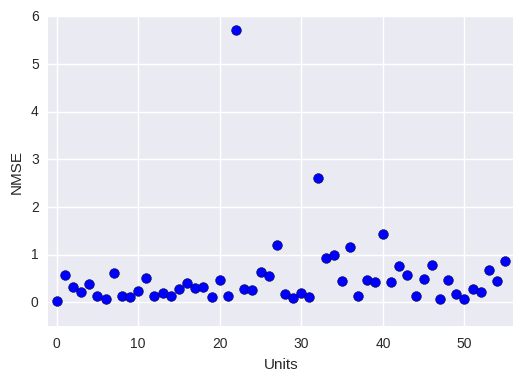

In [54]:
# scatter plot the result
plt.scatter(xrange(len(nmse)), nmse, s=50)
plt.xlim(-1, 56)
plt.ylim(-.5, 6)
plt.xlabel('Units')
plt.ylabel('NMSE')


### 6.3 Mean Square Error weighted by total uncertainty

We further explored the MSE weighted by total uncertainty:

$$
\frac{\mathbb{E} (f_a - f_i)^2}{\sigma_a^2 + \sigma_i^2}
$$

for n time bins w.r.t. each stimulus. Note that this is a ratio of MSE to the sum of variances.

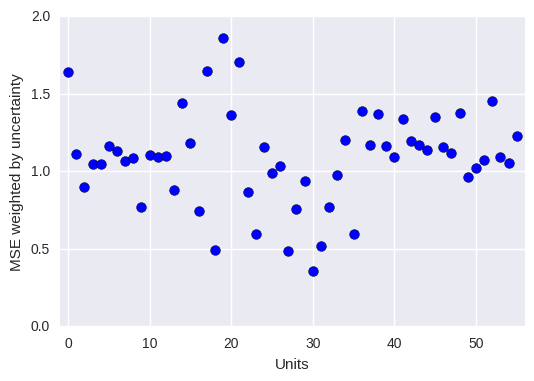

In [55]:
diff = allstats[:, :, 0].T - dfpivot.values
denom = np.var(allstats[:, :, 0].T, axis=0) + np.var(dfpivot.values, axis=0)
wmse = np.mean(diff * diff, axis=0) / denom

plt.scatter(xrange(len(wmse)), wmse, s=50)
plt.xlim(-1, 56)
plt.ylim(0, 2)
plt.xlabel('Units')
plt.ylabel('MSE weighted by uncertainty')

### Plot simulation results

In [56]:
savefig = False

/home/xinchen/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


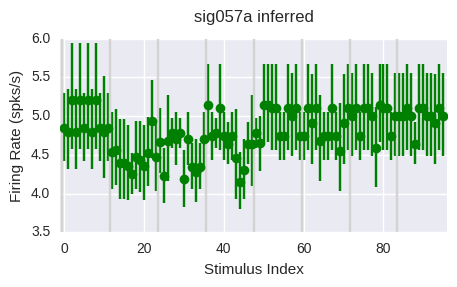

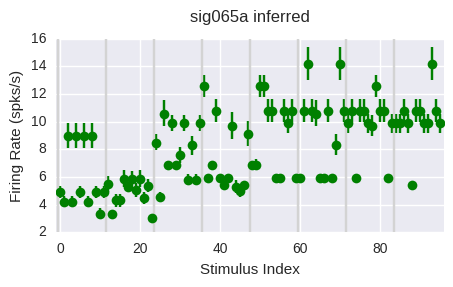

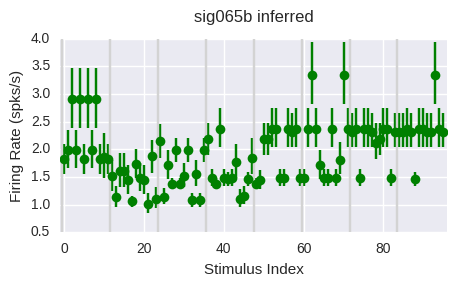

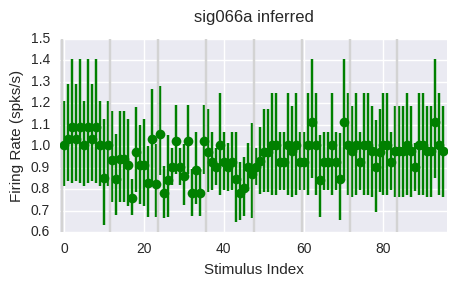

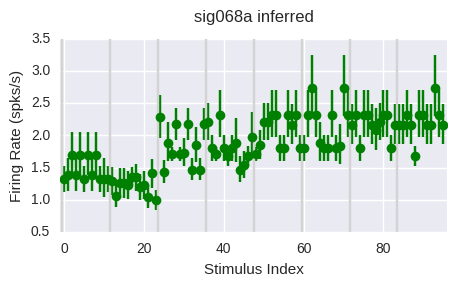

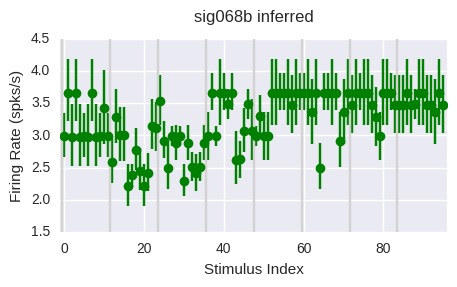

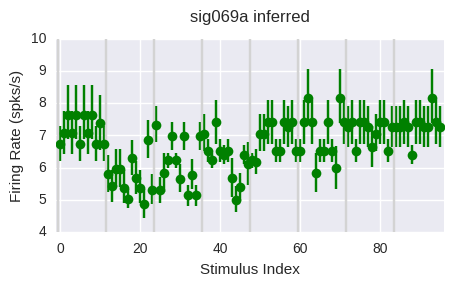

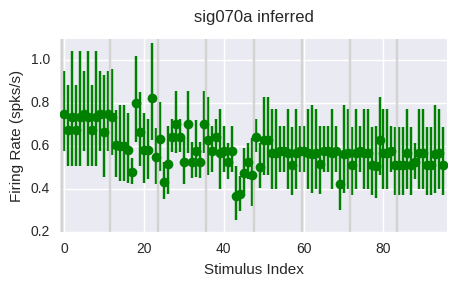

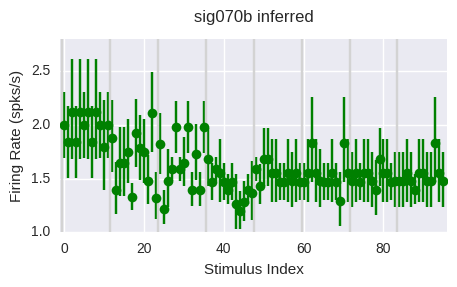

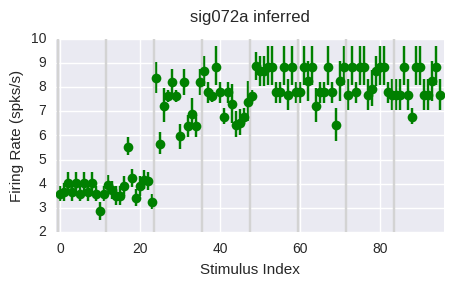

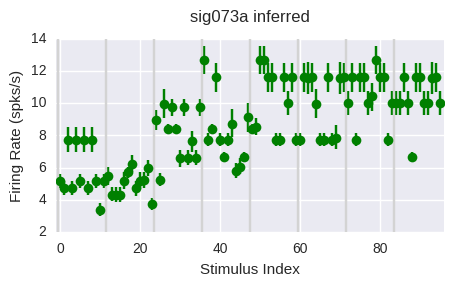

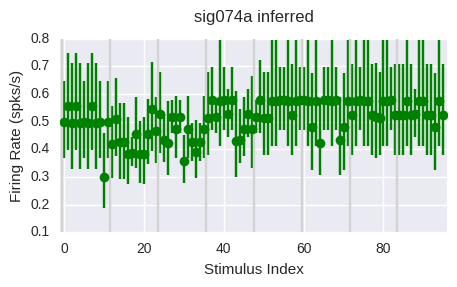

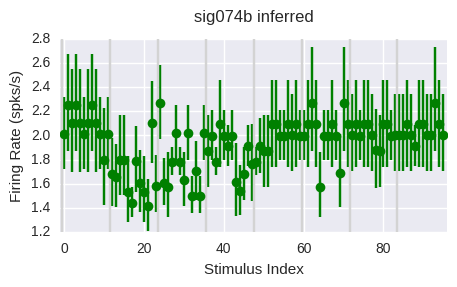

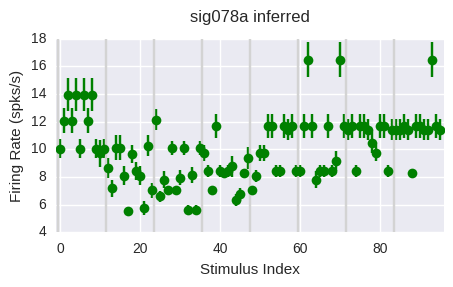

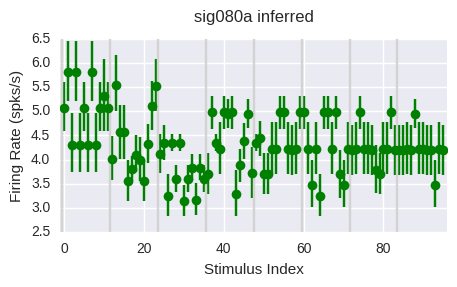

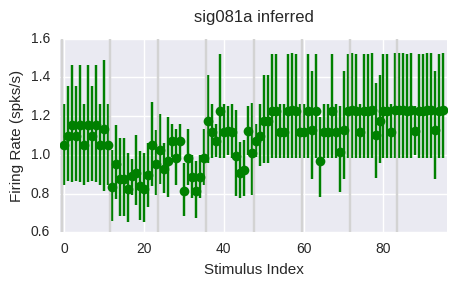

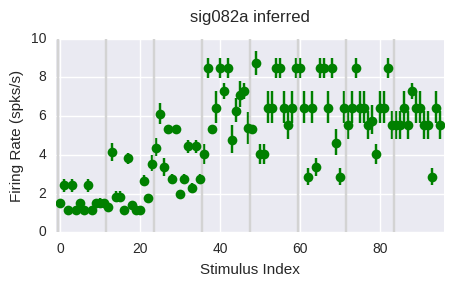

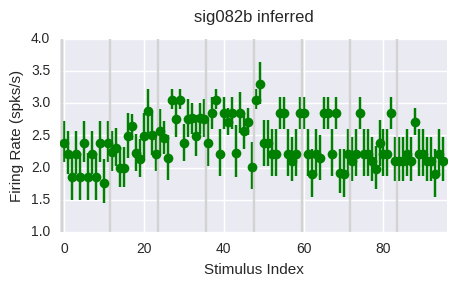

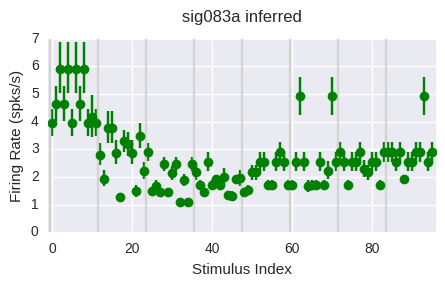

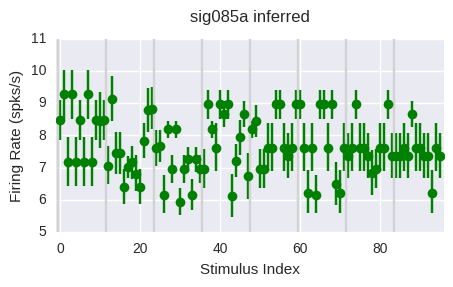

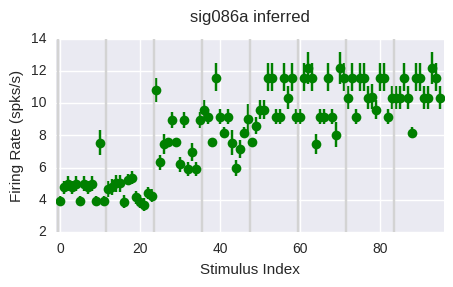

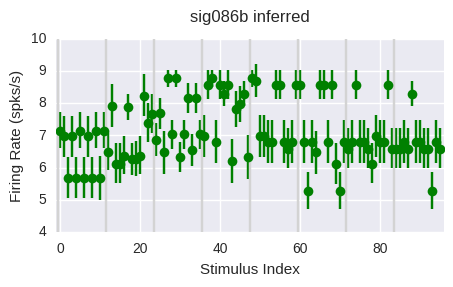

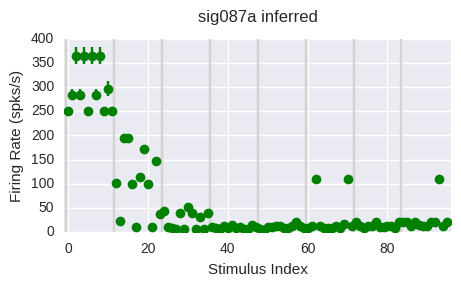

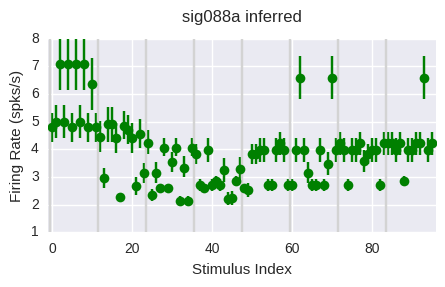

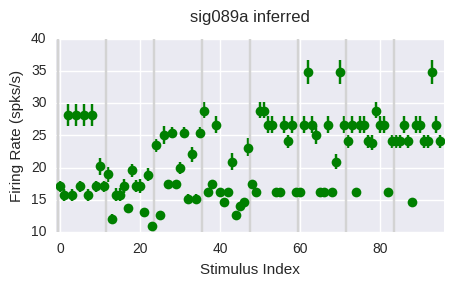

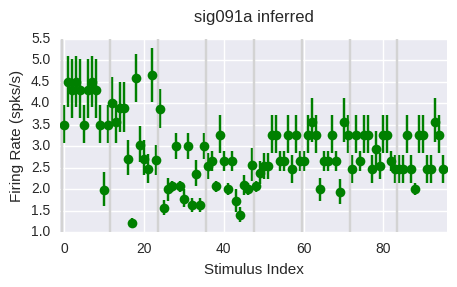

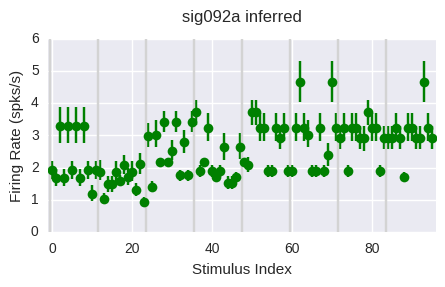

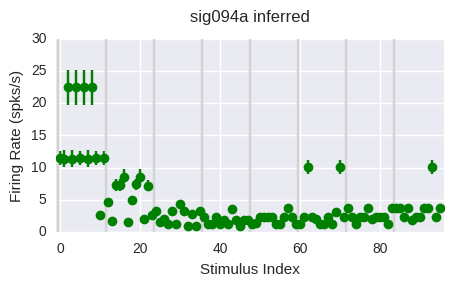

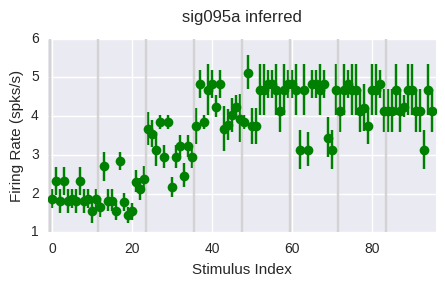

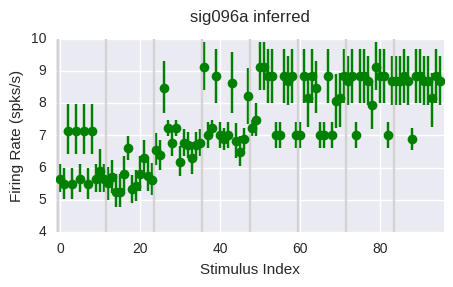

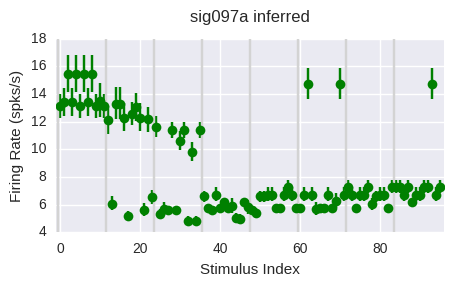

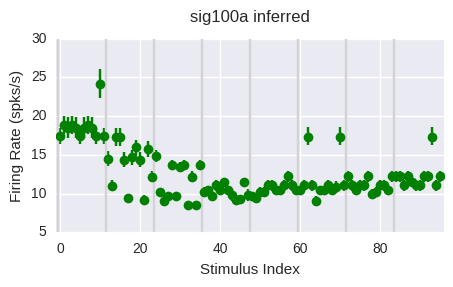

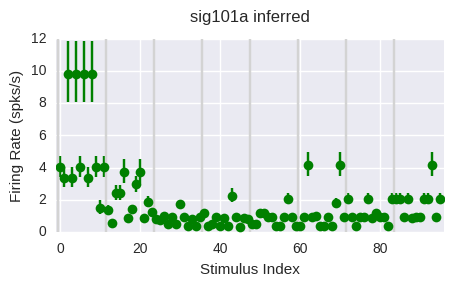

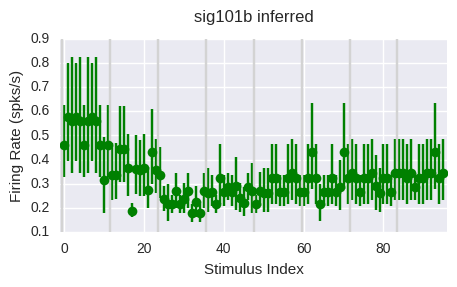

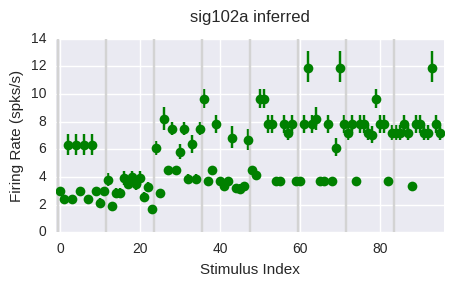

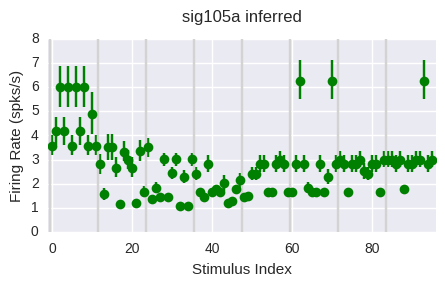

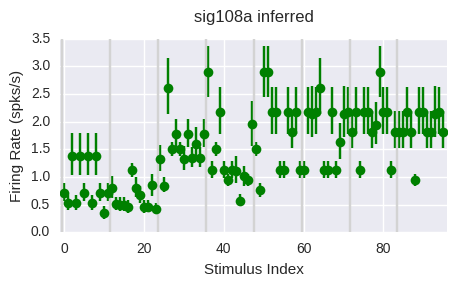

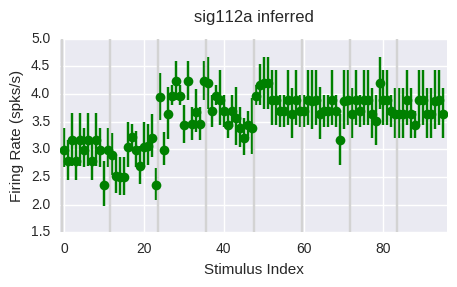

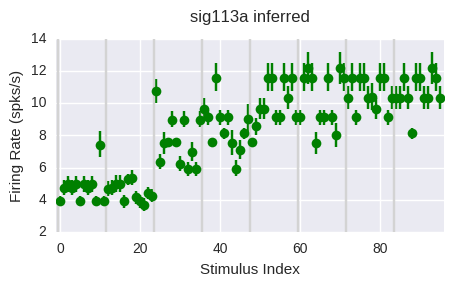

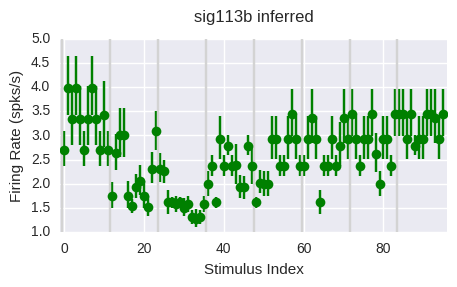

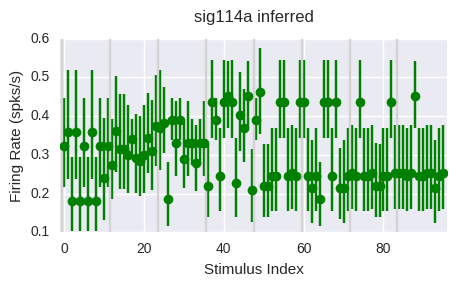

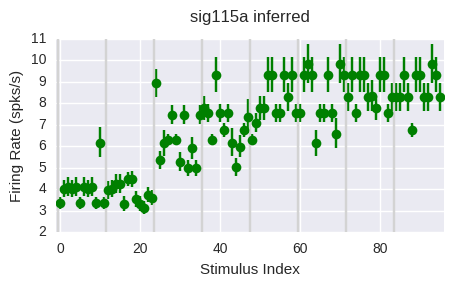

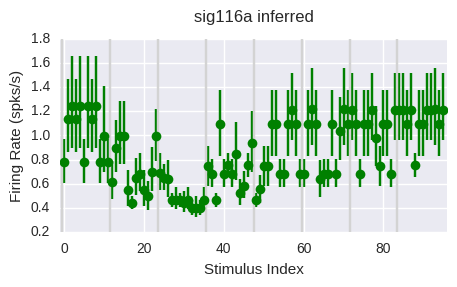

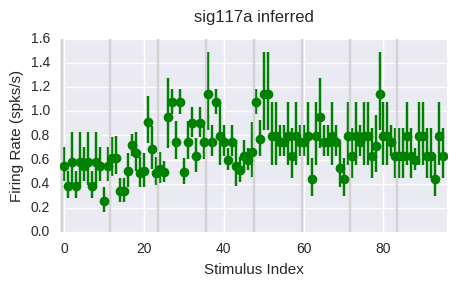

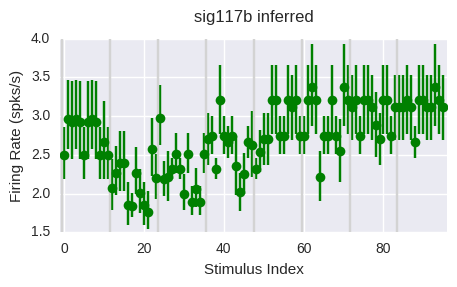

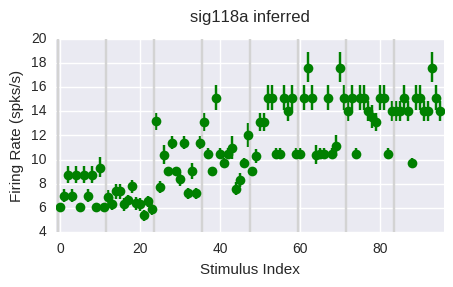

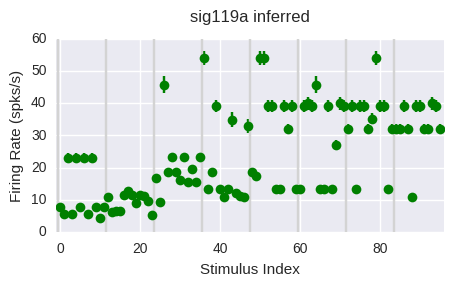

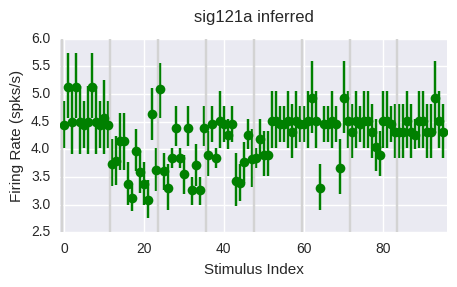

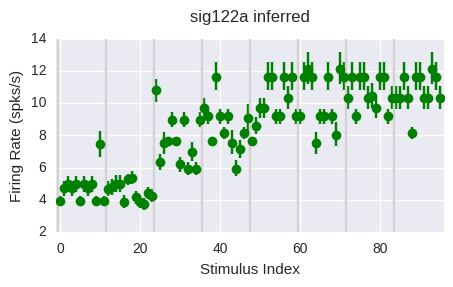

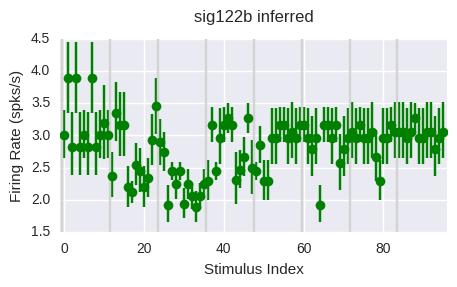

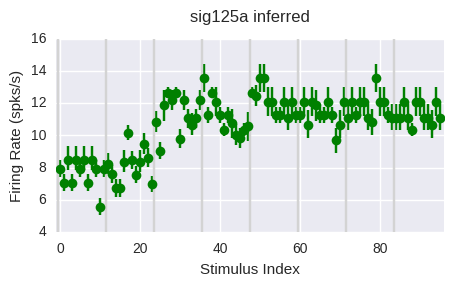

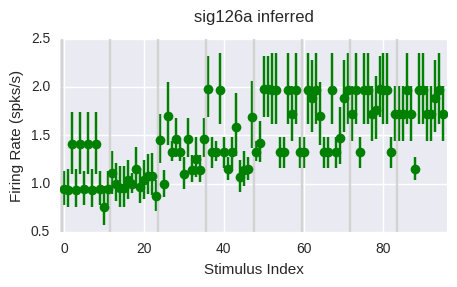

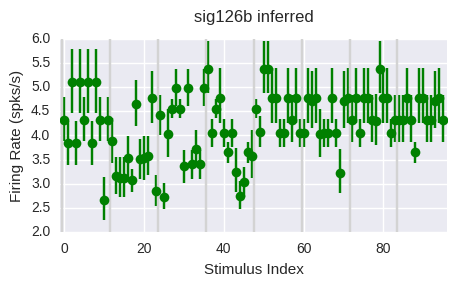

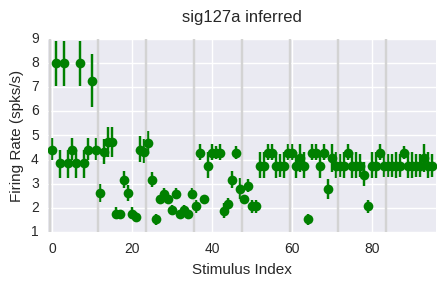

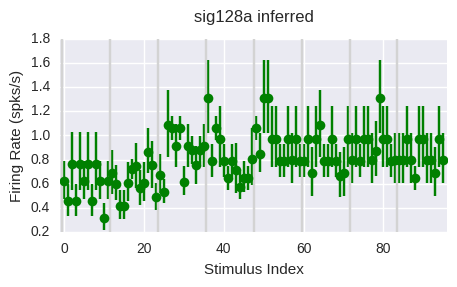

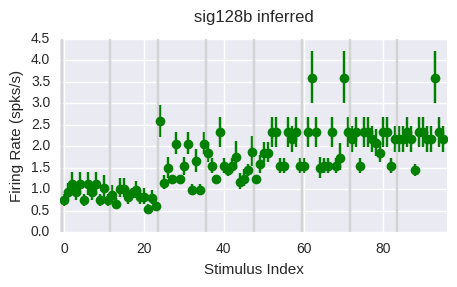

In [57]:
# plot figures from all stats

if savefig:
    # print to pdf using PdfPages
    pp = PdfPages('spikecount_simulations.pdf')
    sns.set_context('talk', font_scale=1.5)
    sns.set_style('white')
    
# Draw pics from simulations
for unit in range(Nu):
    plt.figure(figsize=(5, 2.5))
    plt.title(snames[unit] + ' inferred', y=1.05)
    
    x = np.arange(0, allstats.shape[1], 1)
    y = allstats[unit, :, 0]
    
    for ind in range(0, Nstim, 12):
        plt.axvline(ind - 0.5, color='lightgrey')
    plt.vlines(x, allstats[unit, :, 1], allstats[unit, :, 2], colors='green')
    plt.plot(y, 'go')

    plt.xlim([-1, allstats.shape[1]])
    # plt.ylim([5, 45])
    plt.ylabel('Firing Rate (spks/s)')
    plt.xlabel('Stimulus Index')
    
    if savefig:
        pp.savefig()

if savefig:
    pp.close()